In [1]:
# -*- coding: UTF-8 -*-
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

https://medium.com/google-cloud/how-to-do-time-series-prediction-using-rnns-and-tensorflow-and-cloud-ml-engine-2ad2eeb189e8

In [2]:
from __future__ import division
import tensorflow as tf
from os import path
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from time import time
from matplotlib import pyplot as plt
import seaborn as sns
from mylibs.jupyter_notebook_helper import show_graph
from tensorflow.contrib import rnn
from tensorflow.contrib import learn
import shutil
from tensorflow.contrib.learn.python.learn import learn_runner

Using TensorFlow backend.


In [3]:
dtype = tf.float32
seed = 16011984
random_state = np.random.RandomState(seed=seed)
config = tf.ConfigProto(log_device_placement=True, allow_soft_placement=True)
config.gpu_options.allow_growth = True
%matplotlib inline

In [4]:
SEQ_LEN = 10

In [5]:
rng = np.random.RandomState(seed=0)

In [6]:
def create_time_series():
    freq = (np.random.random()*0.5) + 0.1  # 0.1 to 0.6
    ampl = np.random.random() + 0.5  # 0.5 to 1.5
    x = np.sin(np.arange(0,SEQ_LEN) * freq) * ampl
    return x

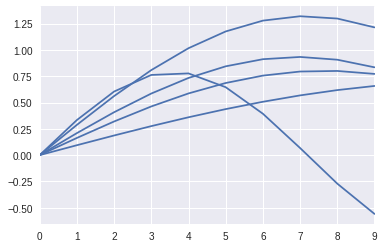

In [7]:
for ii in range(5):
    sns.tsplot(data=create_time_series())
plt.show()

In [8]:
def to_csv(filename, N):
    with open(filename, 'w') as ofp:
        for lineno in xrange(0, N):
            seq = create_time_series()
            line = ",".join(map(str, seq))
            ofp.write(line + '\n')

#to_csv('train.csv', 1000)  # 1000 sequences
#to_csv('valid.csv',  50)

In [9]:
DEFAULTS = [[0.] for x in xrange(0, SEQ_LEN)]  #just all zeros
DEFAULTS

[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]

In [10]:
BATCH_SIZE = 20 #hyperparam

In [11]:
TIMESERIES_COL = 'rawdata'  #we have only one column here
N_OUTPUTS = 2  #in each sequence, 1-8 are features and 9-10 is label
N_INPUTS = SEQ_LEN - N_OUTPUTS

In [12]:
def read_dataset(filename, mode=tf.contrib.learn.ModeKeys.TRAIN):
    
    def _input_fn():
        num_epochs = 100 if mode == tf.contrib.learn.ModeKeys.TRAIN else 1

        #could be a path to one file or a file pattern
        input_file_names = tf.train.match_filenames_once(filename)
        print input_file_names

        filename_queue = tf.train.string_input_producer(input_file_names,
                                                        num_epochs=num_epochs,
                                                        shuffle=True)

        reader = tf.TextLineReader()
        _, value = reader.read_up_to(filename_queue, num_records=BATCH_SIZE)

        value_column = tf.expand_dims(value, -1)
        print "readcsv={}".format(value_column)

        #all data is a list of tensors
        all_data = tf.decode_csv(value_column, record_defaults=DEFAULTS)
        separation = len(all_data)- N_OUTPUTS
        inputs = all_data[:separation]
        label = all_data[separation:]

        #from list of tensors to tensor
        inputs = tf.concat(inputs, axis=1)
        label = tf.concat(label, axis=1)
        print 'inputs={}'.format(inputs)
        print 'label={}'.format(label)

        return {TIMESERIES_COL: inputs}, label  #dict of features, label <-- prescribed
    
    return _input_fn

In [13]:
testfun = read_dataset('train.csv')

In [14]:
graph = tf.Graph()  # create new graph

with graph.as_default():
    testfun()

<tf.Variable 'matching_filenames:0' shape=<unknown> dtype=string_ref>
readcsv=Tensor("ExpandDims:0", shape=(?, 1), dtype=string)
inputs=Tensor("concat:0", shape=(?, 8), dtype=float32)
label=Tensor("concat_1:0", shape=(?, 2), dtype=float32)


In [15]:
show_graph(graph)

In [16]:
#this is the state size
LSTM_SIZE = 3  #number of hidden layers in each of the LSTM cells

In [19]:
#create the inference model
def simple_rnn(features, targets, mode):
    # 0. Reformat input shape to become a sequence
    xx = tf.split(features[TIMESERIES_COL], N_INPUTS, 1)
    print len(xx)
    print "xx={}".format(xx[0])
    print
    
    #1. configure the RNN
    lstm_cell = rnn.BasicLSTMCell(LSTM_SIZE, forget_bias=1.)
    outputs, _ = rnn.static_rnn(cell=lstm_cell, inputs=xx, dtype=dtype)
    
    #slice to keep only the last cell of the RNN
    outputs = outputs[-1]
    print "last out: {}".format(outputs)
    #this is of length 3 because this is the size of layers inside the LSTM cell
    
    weight = tf.Variable(tf.random_normal([LSTM_SIZE, N_OUTPUTS]))
    bias = tf.Variable(tf.random_normal([N_OUTPUTS]))
    predictions = tf.matmul(outputs, weight) + bias
    
    
    #2. define the loss function for training / evaluation
    loss = tf.losses.mean_squared_error(labels=targets, predictions=predictions)
    
    eval_metric_ops = {
        "rmse": tf.metrics.root_mean_squared_error(labels=targets, predictions=predictions)
    }
    
    #3. Define the training operation/optimizer
    train_op = tf.contrib.layers.optimize_loss(
        loss, global_step=tf.contrib.framework.get_global_step(),
        learning_rate=0.01,
        optimizer="SGD"
    )
    
    #4. Create predictions
    predictions_dict = {"predicted": predictions}
    
    #5. return ModelFnOps
    return learn.ModelFnOps(
        mode=mode,
        predictions=predictions_dict,
        loss=loss,
        train_op=train_op,
        eval_metric_ops=eval_metric_ops)

In [20]:
graph = tf.Graph()  # create new graph

with graph.as_default():
    inputs = tf.placeholder(dtype=dtype, shape=(None, 8), name="stream")
    targets = tf.placeholder(dtype=dtype, shape=(None, 2), name="targets")
    
    print simple_rnn(features={TIMESERIES_COL: inputs}, targets=targets, mode=None)

8
xx=Tensor("split:0", shape=(?, 1), dtype=float32)

last out: Tensor("rnn/basic_lstm_cell_7/mul_2:0", shape=(?, 3), dtype=float32)
ModelFnOps(predictions={'predicted': <tf.Tensor 'add:0' shape=(?, 2) dtype=float32>}, loss=<tf.Tensor 'mean_squared_error/value:0' shape=() dtype=float32>, train_op=<tf.Operation 'OptimizeLoss/control_dependency' type=Identity>, eval_metric_ops={'rmse': (<tf.Tensor 'Sqrt:0' shape=() dtype=float32>, <tf.Tensor 'Sqrt_1:0' shape=() dtype=float32>)}, output_alternatives=None, training_chief_hooks=[], training_hooks=[], scaffold=None)


In [29]:
def get_train():
    return read_dataset('train.csv', mode=tf.contrib.learn.ModeKeys.TRAIN)

In [30]:
def get_valid():
    return read_dataset('valid.csv', mode=tf.contrib.learn.ModeKeys.EVAL)

In [32]:
def experiment_fn(output_dir):
    """run experiment"""
    
    estimator = learn.Estimator(model_fn=simple_rnn, model_dir=output_dir)
    
    return learn.Experiment(estimator, train_input_fn=get_train(),
                            eval_input_fn=get_valid(), eval_metrics= {
                                "rmse": learn.MetricSpec(
                                    metric_fn=tf.metrics.root_mean_squared_error
                                )
                            })

In [38]:
OUTPUT_DIR = 'outputdir'

In [39]:
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)  #start fresh

In [44]:
#takes as inputs the experiment function and its arguments
learn_runner.run(experiment_fn=experiment_fn, output_dir=OUTPUT_DIR)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': None, '_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa817409710>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}
Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
<tf.Variable 'matching_filenames:0' shape=<unknown> dtype=string_ref>
readcsv=Tensor("ExpandDims:0", shape=(?, 1), dtype=string)
inputs=Tensor("concat:0", shape=(?, 8), dtype=float32)
label=Tensor("concat_1:0", shape=(?, 2), dtype=float32)
xx=[<tf.Tensor 'split:0' shape=(?, 1) dtype=float32>, <tf.Tens

last out: Tensor("rnn/basic_lstm_cell_7/mul_2:0", shape=(?, 3), dtype=float32)
INFO:tensorflow:Starting evaluation at 2017-06-09-15:29:28
INFO:tensorflow:Restoring parameters from outputdir/model.ckpt-5000
INFO:tensorflow:Evaluation [1/100]
INFO:tensorflow:Evaluation [2/100]
INFO:tensorflow:Evaluation [3/100]
INFO:tensorflow:Finished evaluation at 2017-06-09-15:29:28
INFO:tensorflow:Saving dict for global step 5000: RMSE = 0.246303, global_step = 5000, loss = 0.0671288, rmse = 0.246303


({'RMSE': 0.24630338,
  'global_step': 5000,
  'loss': 0.067128815,
  'rmse': 0.24630338},
 [])

In [31]:
with tf.Session(graph=graph, config=config) as sess:
    print sess.run(tf.constant([5]))

[5]


In [33]:
X_train.shape[0]/512

8.701171875

In [34]:
model.fit(X_train, y_train, batch_size=512, nb_epoch=epochs, validation_split=0.05)

/home/studenthp/anaconda2/envs/dis/lib/python2.7/site-packages/keras/models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 4232 samples, validate on 223 samples
Epoch 1/1
4232/4232 [==============================] - 6s - loss: 0.1963 - val_loss: 0.0306
